#  Time Series Analysis and prediction of Stock Market data using                                                           Deep Learning Techniques

In [66]:

import numpy as np
import pandas as pd
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


import warnings
warnings.filterwarnings('ignore')


import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

### -->Preprocessing of the data

In [67]:
df = pd.read_csv("Stocks/tsla.us.txt")

### chech if the data is stationary or not using Augmented Dickey Fuller Test

In [68]:
from statsmodels.tsa.stattools import adfuller

In [69]:
def adtest(dataset):
    dftest = adfuller(dataset, autolag="AIC")
    print("1. ADF : ", dftest[0])
    print("2. P-VALUES : ", dftest[1])
    print("3. NUM OF LAGS : ", dftest[2])
    print("4. NUM OF OBSERVATIONS USED FOR THE ADF REGRESSION AND CRITICAL VALUES CALCULATION : ", dftest[3])
    print("5. CRITICAL VALUES : ")
    for key, val in dftest[4].items():
        print("\t", key, ": ",val)

In [70]:
adtest(df['Volume'])

1. ADF :  -2.8584722829948017
2. P-VALUES :  0.05039461134316187
3. NUM OF LAGS :  23
4. NUM OF OBSERVATIONS USED FOR THE ADF REGRESSION AND CRITICAL VALUES CALCULATION :  1834
5. CRITICAL VALUES : 
	 1% :  -3.4339205977576532
	 5% :  -2.863117219476073
	 10% :  -2.5676096573745166


In [71]:
df.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,2010-06-28,17.00,17.00,17.00,17.00,0,0
1,2010-06-29,19.00,25.00,17.54,23.89,18783276,0
2,2010-06-30,25.79,30.42,23.30,23.83,17194394,0
3,2010-07-01,25.00,25.92,20.27,21.96,8229863,0
4,2010-07-02,23.00,23.10,18.71,19.20,5141807,0


In [72]:
df.tail()

,Date,Open,High,Low,Close,Volume,OpenInt
1853,2017-11-06,307.00,307.50,299.01,302.78,6482486,0
1854,2017-11-07,301.02,306.50,300.03,306.05,5286320,0
1855,2017-11-08,305.50,306.89,301.30,304.31,4725510,0
1856,2017-11-09,302.50,304.46,296.30,302.99,5440335,0
1857,2017-11-10,302.50,308.36,301.85,302.99,4621912,0


In [73]:
def check_df(dataframe, head=5):
  
    print(dataframe.shape)
   
    print(dataframe.dtypes)

    print(dataframe.head(head))
   
    print(dataframe.tail(head))

    print(dataframe.isnull().sum())
       
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [74]:
check_df(df)

(1858, 7)
Date        object
Open       float64
High       float64
Low        float64
Close      float64
Volume       int64
OpenInt      int64
dtype: object
         Date   Open   High    Low  Close    Volume  OpenInt
0  2010-06-28  17.00  17.00  17.00  17.00         0        0
1  2010-06-29  19.00  25.00  17.54  23.89  18783276        0
2  2010-06-30  25.79  30.42  23.30  23.83  17194394        0
3  2010-07-01  25.00  25.92  20.27  21.96   8229863        0
4  2010-07-02  23.00  23.10  18.71  19.20   5141807        0
            Date    Open    High     Low   Close   Volume  OpenInt
1853  2017-11-06  307.00  307.50  299.01  302.78  6482486        0
1854  2017-11-07  301.02  306.50  300.03  306.05  5286320        0
1855  2017-11-08  305.50  306.89  301.30  304.31  4725510        0
1856  2017-11-09  302.50  304.46  296.30  302.99  5440335        0
1857  2017-11-10  302.50  308.36  301.85  302.99  4621912        0
Date       0
Open       0
High       0
Low        0
Close      0
Volume    

In [75]:
df["Date"]=pd.to_datetime(df["Date"])

In [76]:
df.head()


,Date,Open,High,Low,Close,Volume,OpenInt
0,2010-06-28,17.00,17.00,17.00,17.00,0,0
1,2010-06-29,19.00,25.00,17.54,23.89,18783276,0
2,2010-06-30,25.79,30.42,23.30,23.83,17194394,0
3,2010-07-01,25.00,25.92,20.27,21.96,8229863,0
4,2010-07-02,23.00,23.10,18.71,19.20,5141807,0


In [77]:
Stock_df= df[["Date","Close"]]

In [78]:
Stock_df.head()

,Date,Close
0,2010-06-28,17.00
1,2010-06-29,23.89
2,2010-06-30,23.83
3,2010-07-01,21.96
4,2010-07-02,19.20


In [79]:
print("Min. Date:",Stock_df["Date"].min())
print("Max. Date:",Stock_df["Date"].max())

Min. Date: 2010-06-28 00:00:00
Max. Date: 2017-11-10 00:00:00


In [80]:
Stock_df.index=Stock_df["Date"]

In [81]:
Stock_df

,Date,Close
Date,,
2010-06-28,2010-06-28,17.00
2010-06-29,2010-06-29,23.89
2010-06-30,2010-06-30,23.83
2010-07-01,2010-07-01,21.96
2010-07-02,2010-07-02,19.20
...,...,...
2017-11-06,2017-11-06,302.78
2017-11-07,2017-11-07,306.05
2017-11-08,2017-11-08,304.31


In [82]:
Stock_df.drop("Date",axis=1,inplace=True)

In [83]:
Stock_df

,Close
Date,
2010-06-28,17.00
2010-06-29,23.89
2010-06-30,23.83
2010-07-01,21.96
2010-07-02,19.20
...,...
2017-11-06,302.78
2017-11-07,306.05
2017-11-08,304.31


In [84]:
result_df=Stock_df.copy()

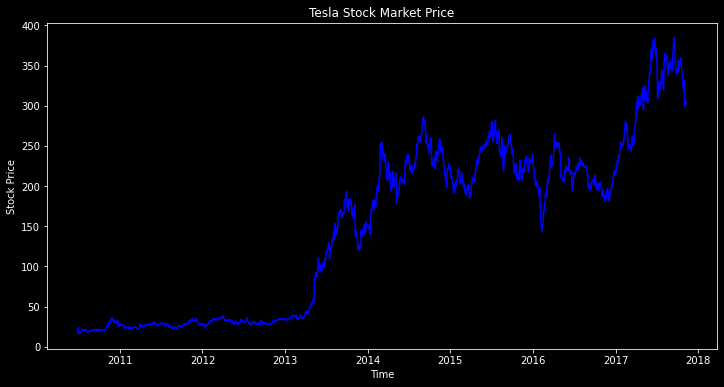

In [85]:
plt.figure(figsize=(12,6))
plt.plot(Stock_df["Close"],color="blue");
plt.ylabel("Stock Price")
plt.title("Tesla Stock Market Price")
plt.xlabel("Time")
plt.show()

In [86]:
Stock_df=Stock_df.values

In [87]:
Stock_df[0:5]

array([[17.  ],
       [23.89],
       [23.83],
       [21.96],
       [19.2 ]])

In [88]:
Stock_df=Stock_df.astype("float32")

### ->Training and testing the model

In [89]:
pos=int(round(len(Stock_df)*(1-0.20)))
train=Stock_df[:pos]
test=Stock_df[pos:]

In [90]:
''''def split_data(dataframe,test_size):
    pos=int(round(len(dataframe)*(1-test_size)))
    train=dataframe[:pos]
    test=dataframe[pos:]
    return train,test,pos '''

"'def split_data(dataframe,test_size):\n    pos=int(round(len(dataframe)*(1-test_size)))\n    train=dataframe[:pos]\n    test=dataframe[pos:]\n    return train,test,pos "

In [91]:
### train,test,pos=split_data(Stock_df,0.20)

In [92]:
print(train.shape,test.shape)

(1486, 1) (372, 1)


In [93]:
scaler_train=MinMaxScaler(feature_range=(0,1))

In [94]:
train=scaler_train.fit_transform(train)

In [95]:
scaler_test=MinMaxScaler(feature_range=(0,1))

In [96]:
test=scaler_test.fit_transform(test)

In [97]:
train[0:5]

array([[0.00444049],
       [0.02993634],
       [0.02971432],
       [0.02279454],
       [0.01258141]], dtype=float32)

In [98]:
test[0:5]

array([[0.17912066],
       [0.187325  ],
       [0.21454191],
       [0.20432329],
       [0.2052567 ]], dtype=float32)

In [99]:
def create_features(data,lookback):
    X,Y=[],[]
    for i in range(lookback,len(data)):
        X.append(data[i-lookback:i,0])
        Y.append(data[i,0])
    return np.array(X),np.array(Y)

In [100]:
lookback=30

In [101]:
X_train,y_train=create_features(train,lookback)

In [102]:
X_test,y_test=create_features(test,lookback)

In [103]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(1456, 30) (1456,) (342, 30) (342,)


In [104]:
X_train[0:5]

array([[0.00444049, 0.02993634, 0.02971432, 0.02279454, 0.01258141,
        0.00114713, 0.        , 0.00614268, 0.00592066, 0.00462551,
        0.00865897, 0.01494967, 0.01513469, 0.01791   , 0.02260953,
        0.01665186, 0.01635583, 0.01924215, 0.02031527, 0.01905713,
        0.01757696, 0.01820603, 0.01683688, 0.01531971, 0.01894612,
        0.02275755, 0.02020426, 0.01720693, 0.01402457, 0.01406157],
       [0.02993634, 0.02971432, 0.02279454, 0.01258141, 0.00114713,
        0.        , 0.00614268, 0.00592066, 0.00462551, 0.00865897,
        0.01494967, 0.01513469, 0.01791   , 0.02260953, 0.01665186,
        0.01635583, 0.01924215, 0.02031527, 0.01905713, 0.01757696,
        0.01820603, 0.01683688, 0.01531971, 0.01894612, 0.02275755,
        0.02020426, 0.01720693, 0.01402457, 0.01406157, 0.01195234],
       [0.02971432, 0.02279454, 0.01258141, 0.00114713, 0.        ,
        0.00614268, 0.00592066, 0.00462551, 0.00865897, 0.01494967,
        0.01513469, 0.01791   , 0.02260953, 0.

In [105]:
y_test[0:5]

array([0.16944242, 0.1735692 , 0.21287155, 0.21223283, 0.20181775],
      dtype=float32)

In [106]:
X_train=np.reshape(X_train,(X_train.shape[0],1,X_train.shape[1]))

In [107]:
X_test=np.reshape(X_test,(X_test.shape[0],1,X_test.shape[1]))

In [108]:
y_train=y_train.reshape(-1,1)

In [109]:
y_test=y_test.reshape(-1,1)

In [110]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(1456, 1, 30) (1456, 1) (342, 1, 30) (342, 1)


In [111]:
def ANN(m):
    from keras.models import Sequential
    from keras.layers import Dense
   
    model.add(Dense(11,activation='relu',input_dim=30))
    model.add(Dense(1,activation='sigmoid'))

    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.fit(X_train,y_train,epochs=3)

In [112]:
from lib.utils import *
ac=[]

In [113]:
model=ANN(X_train)

In [114]:
model.compile(loss="mean_squared_error",optimizer="adam")


In [115]:
callbacks=[EarlyStopping(monitor="val_loss",patience=3,verbose=1,mode="min"),
          ModelCheckpoint(filepath="mymodel.h5",monitor="val_loss",mode="min",
                         save_best_only=True,save_weights_only=False,verbose=1)]

In [116]:
history = model.fit(x=X_train,
                    y=y_train,
                    epochs=200,
                    batch_size=30,
                    validation_data=(X_test,y_test),
                    callbacks=callbacks,
                    shuffle=False)
ac.append(accuracy_score(model,y_test,sample_weight=0.2)*100)

Epoch 1/200
49/49 [==============================] - ETA: 0s - loss: 0.0084    
Epoch 1: val_loss improved from inf to 0.00877, saving model to mymodel.h5
49/49 [==============================] - 2s 12ms/step - loss: 0.0084 - val_loss: 0.0088
Epoch 2/200
45/49 [==========================>...] - ETA: 0s - loss: 0.0056
Epoch 2: val_loss improved from 0.00877 to 0.00737, saving model to mymodel.h5
49/49 [==============================] - 0s 5ms/step - loss: 0.0060 - val_loss: 0.0074
Epoch 3/200
33/49 [===================>..........] - ETA: 0s - loss: 0.0030    
Epoch 3: val_loss improved from 0.00737 to 0.00648, saving model to mymodel.h5
49/49 [==============================] - 0s 5ms/step - loss: 0.0050 - val_loss: 0.0065
Epoch 4/200
34/49 [===================>..........] - ETA: 0s - loss: 0.0023    
Epoch 4: val_loss improved from 0.00648 to 0.00600, saving model to mymodel.h5
49/49 [==============================] - 0s 5ms/step - loss: 0.0042 - val_loss: 0.0060
Epoch 5/200
33/49 [====

In [117]:
loss=model.evaluate(X_test,y_test,batch_size=30)

12/12 [==============================] - 0s 2ms/step - loss: 0.0039


In [118]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

11/11 [==============================] - 0s 2ms/step


In [119]:
train_predict=scaler_train.inverse_transform(train_predict)
test_predict=scaler_test.inverse_transform(test_predict)

In [120]:
y_train=scaler_train.inverse_transform(y_train)
y_test=scaler_test.inverse_transform(y_test)

In [121]:
train_rmse=np.sqrt(mean_squared_error(y_train,train_predict))

In [122]:
test_rmse=np.sqrt(mean_squared_error(y_test,test_predict,))

In [123]:
train_prediction_data=result_df[lookback:pos]

In [124]:
train_prediction_data["Predicted"]=train_predict

In [125]:
test_prediction_data=result_df[pos+lookback:]

In [126]:
test_prediction_data["Predicted"]=test_predict

In [127]:
print("Daily predcition")
test_prediction_data.head()

Daily predcition


,Close,Predicted
Date,,
2016-07-07,215.94,219.136734
2016-07-08,216.78,220.418488
2016-07-11,224.78,220.413452
2016-07-12,224.65,221.754776
2016-07-13,222.53,222.722641


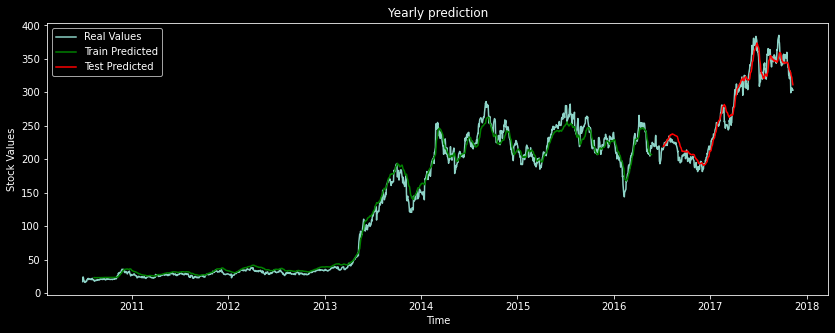

In [128]:
plt.figure(figsize=(14,5))
plt.plot(result_df,label="Real Values")
plt.plot(train_prediction_data["Predicted"],color="green",label="Train Predicted")
plt.plot(test_prediction_data["Predicted"],color="red",label="Test Predicted")
plt.title("Yearly prediction")
plt.xlabel("Time")
plt.ylabel("Stock Values")
plt.legend()
plt.show()

In [129]:
from sklearn import tree
from sklearn import preprocessing
lab = preprocessing.LabelEncoder()
y_transformed = lab.fit_transform(y_train)

model=tree.DecisionTreeClassifier()
model.fit(X_train.reshape(1456,-1),y_transformed)
y_pred=model.predict(X_test.reshape(342,-1))
ac.append(accuracy_score(y_pred,y_test,sample_weight=0.8)*100)

the accuracy of Decision Tree is 94.19999999999999 and ANN is 96.00999999999999


(50.0, 100.0)

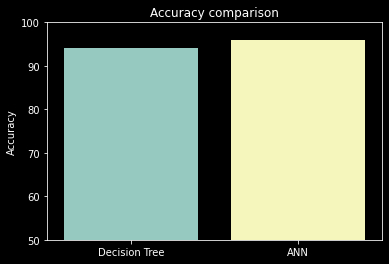

In [130]:
import numpy as np
import seaborn as sns
import matplotlib as plt

plt.style.use('dark_background')
x=['Decision Tree','ANN']
ac.reverse()
ax=sns.barplot(x,ac)
ax.set_title('Accuracy comparison')
ax.set_ylabel('Accuracy')
#ax.yaxis.set_major_locator(ticker.LinearLocator())
print("the accuracy of {} is {} and {} is {}".format(x[0],ac[0],x[1],ac[1]))
ax.set_ylim(50,100)